In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

import pandas as pd
import numpy as np

import requests as re
import json
import geopandas as gpd
from shapely import geometry
from matplotlib import pyplot as plt
import pymssql  
## load packages
import networkx as nx
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
import datetime

In [2]:
icd=pd.read_feather(r'F:\LK20190910.feather')

In [ ]:
# bus_station
df3=pd.read_csv('data\bus_station.csv',encoding='gbk')
df3=df3.drop(columns='Unnamed: 0')
def split_x22(x):
    return x+'_b'
df3['station']=df3['station'].apply(lambda x:split_x22(x))

In [ ]:
# metro_station
df4=pd.read_csv('data\metro_station.csv',encoding='gbk')
df4=df4.drop(columns='Unnamed: 0')
def split_x32(x):
    return x+'_m'
df4['station']=df4['station'].apply(lambda x:split_x32(x))

###  2 stations

In [6]:
c='wertyuDT'
c[-2::]=='DT'

True

In [7]:
#
def new_station(x1,x2):
    if x1[-2::]=='DT':
        x2=x2+'_m'
    if x1[-2::]=='GJ':
        x2=x2+'_b'
    return x2
def split_x(x):
    x1=x['f_mode']
    x2=x['fst_name']
    x3=x['t_mode']
    x4=x['tst_name']
    return [new_station(x1,x2),new_station(x3,x4)]
sis=icd[['f_mode','fst_name','t_mode','tst_name']].apply(lambda x:split_x(x),axis=1)

In [8]:
a1=np.zeros(icd.shape[0])
icd['fst_name1']=a1
icd['tst_name1']=a1

In [9]:
dfs=pd.DataFrame(list(sis))
dfs=dfs.rename(columns={0:'fst_name',1:'tst_name'})
icd[['fst_name1','tst_name1']]=dfs[['fst_name','tst_name']]
icd.head(1)

card_id f_mode f_line f_dir fst_num fst_name       f_lon      f_lat  \
0  034839834494   \tDT      2     0      14      东直门  116.435842  39.941626   

             f_tm t_mode t_line t_dir tst_num tst_name       t_lon      t_lat  \
0  20190910083400    #DT      2     0      10      北京站  116.427287  39.904983   

             t_tm fst_name1 tst_name1  
0  20190910084757     东直门_m     北京站_m

In [10]:
sti1=list(df3['station'])
print(len(sti1))
sti2=list(df4['station'])
print(len(sti2))
st3=sti1.copy()
st3.extend(sti2)
dfsts=pd.DataFrame(st3)
dfsts=dfsts.rename(columns={0:'fst_name1'})
dfsts['tst_name1']=dfsts['fst_name1']
dfsts.head(1)

7184
282


fst_name1 tst_name1
0    霍营北口_b    霍营北口_b

In [11]:
icd1=icd.merge(dfsts,how='inner',on='fst_name1')
dfsts['tst_name1_x']=dfsts['tst_name1']
icd2=icd1.merge(dfsts,how='inner',on='tst_name1_x')
icd2.head(1)

card_id f_mode f_line f_dir fst_num fst_name       f_lon      f_lat  \
0  034839834494   \tDT      2     0      14      东直门  116.435842  39.941626   

             f_tm t_mode  ... tst_num tst_name       t_lon      t_lat  \
0  20190910083400    #DT  ...      10      北京站  116.427287  39.904983   

             t_tm fst_name1_x tst_name1_x tst_name1_y fst_name1_y tst_name1  
0  20190910084757       东直门_m       北京站_m       东直门_m       北京站_m     北京站_m  

[1 rows x 22 columns]

In [12]:
icd3=icd2[['card_id','fst_name1_x','f_tm','tst_name1_x','t_tm','f_line','t_line']]
icd4=icd3.rename(columns={'fst_name1_x':'fst_name','tst_name1_x':'tst_name'})
icd4.head(1)

card_id fst_name            f_tm tst_name            t_tm f_line  \
0  034839834494    东直门_m  20190910083400    北京站_m  20190910084757      2   

  t_line  
0      2

In [13]:
icd4.head(1)

card_id fst_name            f_tm tst_name            t_tm f_line  \
0  034839834494    东直门_m  20190910083400    北京站_m  20190910084757      2   

  t_line  
0      2

In [14]:
def split_t(x):
    return datetime.datetime.strptime(x, "%Y%m%d%H%M%S")
icd4['f_tm']=icd4['f_tm'].apply(lambda x:split_t(x))
icd4['t_tm']=icd4['t_tm'].apply(lambda x:split_t(x))
icd4.head(1)

card_id fst_name                f_tm tst_name                t_tm  \
0  034839834494    东直门_m 2019-09-10 08:34:00    北京站_m 2019-09-10 08:47:57   

  f_line t_line  
0      2      2

## 3 OD需求提取

    6：00-9：00

In [15]:
def obtain_t(x):
    return x.time().hour
icd4['f_hour']=np.zeros(icd4.shape[0])
icd4['t_hour']=np.zeros(icd4.shape[0])
icd4['f_hour']=icd4['f_tm'].apply(lambda x:obtain_t(x))
icd4['t_hour']=icd4['t_tm'].apply(lambda x:obtain_t(x))
icd4.head(1)

card_id fst_name                f_tm tst_name                t_tm  \
0  034839834494    东直门_m 2019-09-10 08:34:00    北京站_m 2019-09-10 08:47:57   

  f_line t_line  f_hour  t_hour  
0      2      2       8       8

In [16]:
icd5=icd4[(icd4['f_hour']>=6)&(icd4['f_hour']<=9)]
icd6=icd5[(icd5['t_hour']>=6)&(icd5['f_hour']<=9)]
icd6.head()

card_id fst_name                f_tm tst_name                t_tm  \
0   034839834494    东直门_m 2019-09-10 08:34:00    北京站_m 2019-09-10 08:47:57   
2   322299612151    东直门_m 2019-09-10 08:05:00    北京站_m 2019-09-10 08:30:17   
8   866829529322    东直门_m 2019-09-10 09:22:00    北京站_m 2019-09-10 09:40:35   
10  255931616573    东直门_m 2019-09-10 08:07:00    北京站_m 2019-09-10 08:20:18   
13  430903783912    东直门_m 2019-09-10 08:20:00    北京站_m 2019-09-10 08:33:44   

   f_line t_line  f_hour  t_hour  
0       2      2       8       8  
2       2      2       8       8  
8      13      2       9       9  
10      2      2       8       8  
13      2      2       8       8

In [19]:
df5=pd.concat([df3,df4])
print(df5.shape)
df5.head(1)

(7466, 4)


station        lng       lat                    geometry
0  霍营北口_b  116.36554  40.08844  POINT (116.36554 40.08844)

In [21]:
icd6[icd6['fst_name']==icd6['tst_name']].shape

(164071, 9)

In [22]:
# 构建OD表
sts=list(df5['station'])
flowadj=np.zeros([len(sts),len(sts)])
for i in range(icd6.shape[0]):
    orgi=icd6.iloc[i,1]
    dsti=icd6.iloc[i,3]
    id1=sts.index(orgi)
    id2=sts.index(dsti)
    #if orgi==dsti:
    flowadj[id1,id2]=flowadj[id1,id2]+1
for i in range(flowadj.shape[0]):
    if flowadj[i,i]!=0:
        flowadj[i,i]=0
dfflowadj=pd.DataFrame(flowadj)
dfflowadj.index=sts
dfflowadj.columns=sts
dfflowadj.head(1)

霍营北口_b  新苑街_b  建功北里_b  万盛北里_b  莲怡园北路_b  百望山森林公园_b  焦王庄北口_b  小马厂_b  \
霍营北口_b     0.0    0.0     0.0     0.0      0.0        0.0      0.0    0.0   

        广阳大街_b  天通东苑二区_b  ...  北土城_m  陶然桥_m  郭公庄_m  北京西站_m  马家堡_m  天通苑南_m  \
霍营北口_b     0.0       0.0  ...    0.0    0.0    0.0     0.0    0.0     0.0   

        临河里_m  张郭庄_m  永定门外_m  化工_m  
霍营北口_b    0.0    0.0     0.0   0.0  

[1 rows x 7466 columns]

In [24]:
dfflowadj.to_csv('公交-地铁的客流需求量.csv',encoding='gbk',index=False)

In [23]:
dfflowadj=pd.read_csv('公交-地铁的客流需求量.csv',encoding='gbk')

dfflowadj.head(1)

霍营北口_b  新苑街_b  建功北里_b  万盛北里_b  莲怡园北路_b  百望山森林公园_b  焦王庄北口_b  小马厂_b  广阳大街_b  \
0     0.0    0.0     0.0     0.0      0.0        0.0      0.0    0.0     0.0   

   天通东苑二区_b  ...  北土城_m  陶然桥_m  郭公庄_m  北京西站_m  马家堡_m  天通苑南_m  临河里_m  张郭庄_m  \
0       0.0  ...    0.0    0.0    0.0     0.0    0.0     0.0    0.0    0.0   

   永定门外_m  化工_m  
0     0.0   0.0  

[1 rows x 7466 columns]

### 3.2 OD需求可视化 

In [3]:
# 北京面域
beij=gpd.read_file('shapefile\\beij_fq.shp')

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


C:\ProgramData\Anaconda3\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


<AxesSubplot:>

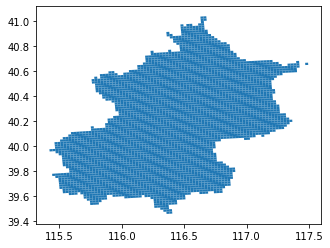

In [4]:
beijnet=gpd.read_file(r'数据处理\shapefile\beij_net_2000.shp',encoding='utf-8')
beijnet.plot()

<AxesSubplot:>

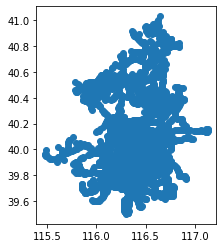

In [9]:
gemmbs = gpd.GeoDataFrame(df5[['station','lng','lat']],geometry=gpd.points_from_xy(df5['lng'],df5['lat']),crs='epsg:4326')
gemmbs.plot()

In [10]:
beijnet=beijnet.reset_index()
beijnet=beijnet.drop(columns='index_righ')
beijnet=beijnet.rename(columns={'index':'net_id'})
beijnet.head(1)

net_id    省     省代码  省类型                                           geometry
0       0  北京市  110000  直辖市  POLYGON ((115.44341 39.75918, 115.44145 39.777...

In [12]:
nst = gpd.sjoin(gemmbs,beijnet, predicate='within')
nst.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  """Entry point for launching an IPython kernel.


station        lng       lat                    geometry  \
0         霍营北口_b  116.36554  40.08844  POINT (116.36554 40.08844)   
228      龙锦苑一区_b  116.35819  40.08708  POINT (116.35819 40.08708)   
356      龙锦苑四区_b  116.34607  40.08667  POINT (116.34607 40.08667)   
1027      马连店东_b  116.34738  40.09897  POINT (116.34738 40.09897)   
2200  和谐家园一区东门_b  116.36295  40.08571  POINT (116.36295 40.08571)   

      index_right  net_id    省     省代码  省类型  
0            1712    1712  北京市  110000  直辖市  
228          1712    1712  北京市  110000  直辖市  
356          1712    1712  北京市  110000  直辖市  
1027         1712    1712  北京市  110000  直辖市  
2200         1712    1712  北京市  110000  直辖市

In [13]:
flowadj=dfflowadj.values

In [14]:
netfs=np.zeros(beijnet.shape[0])
netxy=np.zeros(beijnet.shape[0])
# 方格出行量统计
fasflow=np.sum(flowadj,axis=1) # 发生量
xyflow=np.sum(flowadj,axis=0)  # 吸引量
# hangai net
hgnet=list(set(list(nst['net_id'])))
sts_all=list(dfflowadj.columns)
for i in range(len(hgnet)):
    neti=hgnet[i]
    netsi=nst[nst['net_id']==neti]['station'].to_list()
    idsi=[sts_all.index(c) for c in netsi]
    netfs[neti]=sum(fasflow[idsi])
    netxy[neti]=sum(xyflow[idsi])
print(sum(netfs))
print(sum(netxy))
beijnet['fsflow']=netfs
beijnet['xyflow']=netxy

2926337.0
2926822.0


In [15]:
beijnet1=beijnet[beijnet['fsflow']!=0]
beijnet2=beijnet[beijnet['xyflow']!=0]

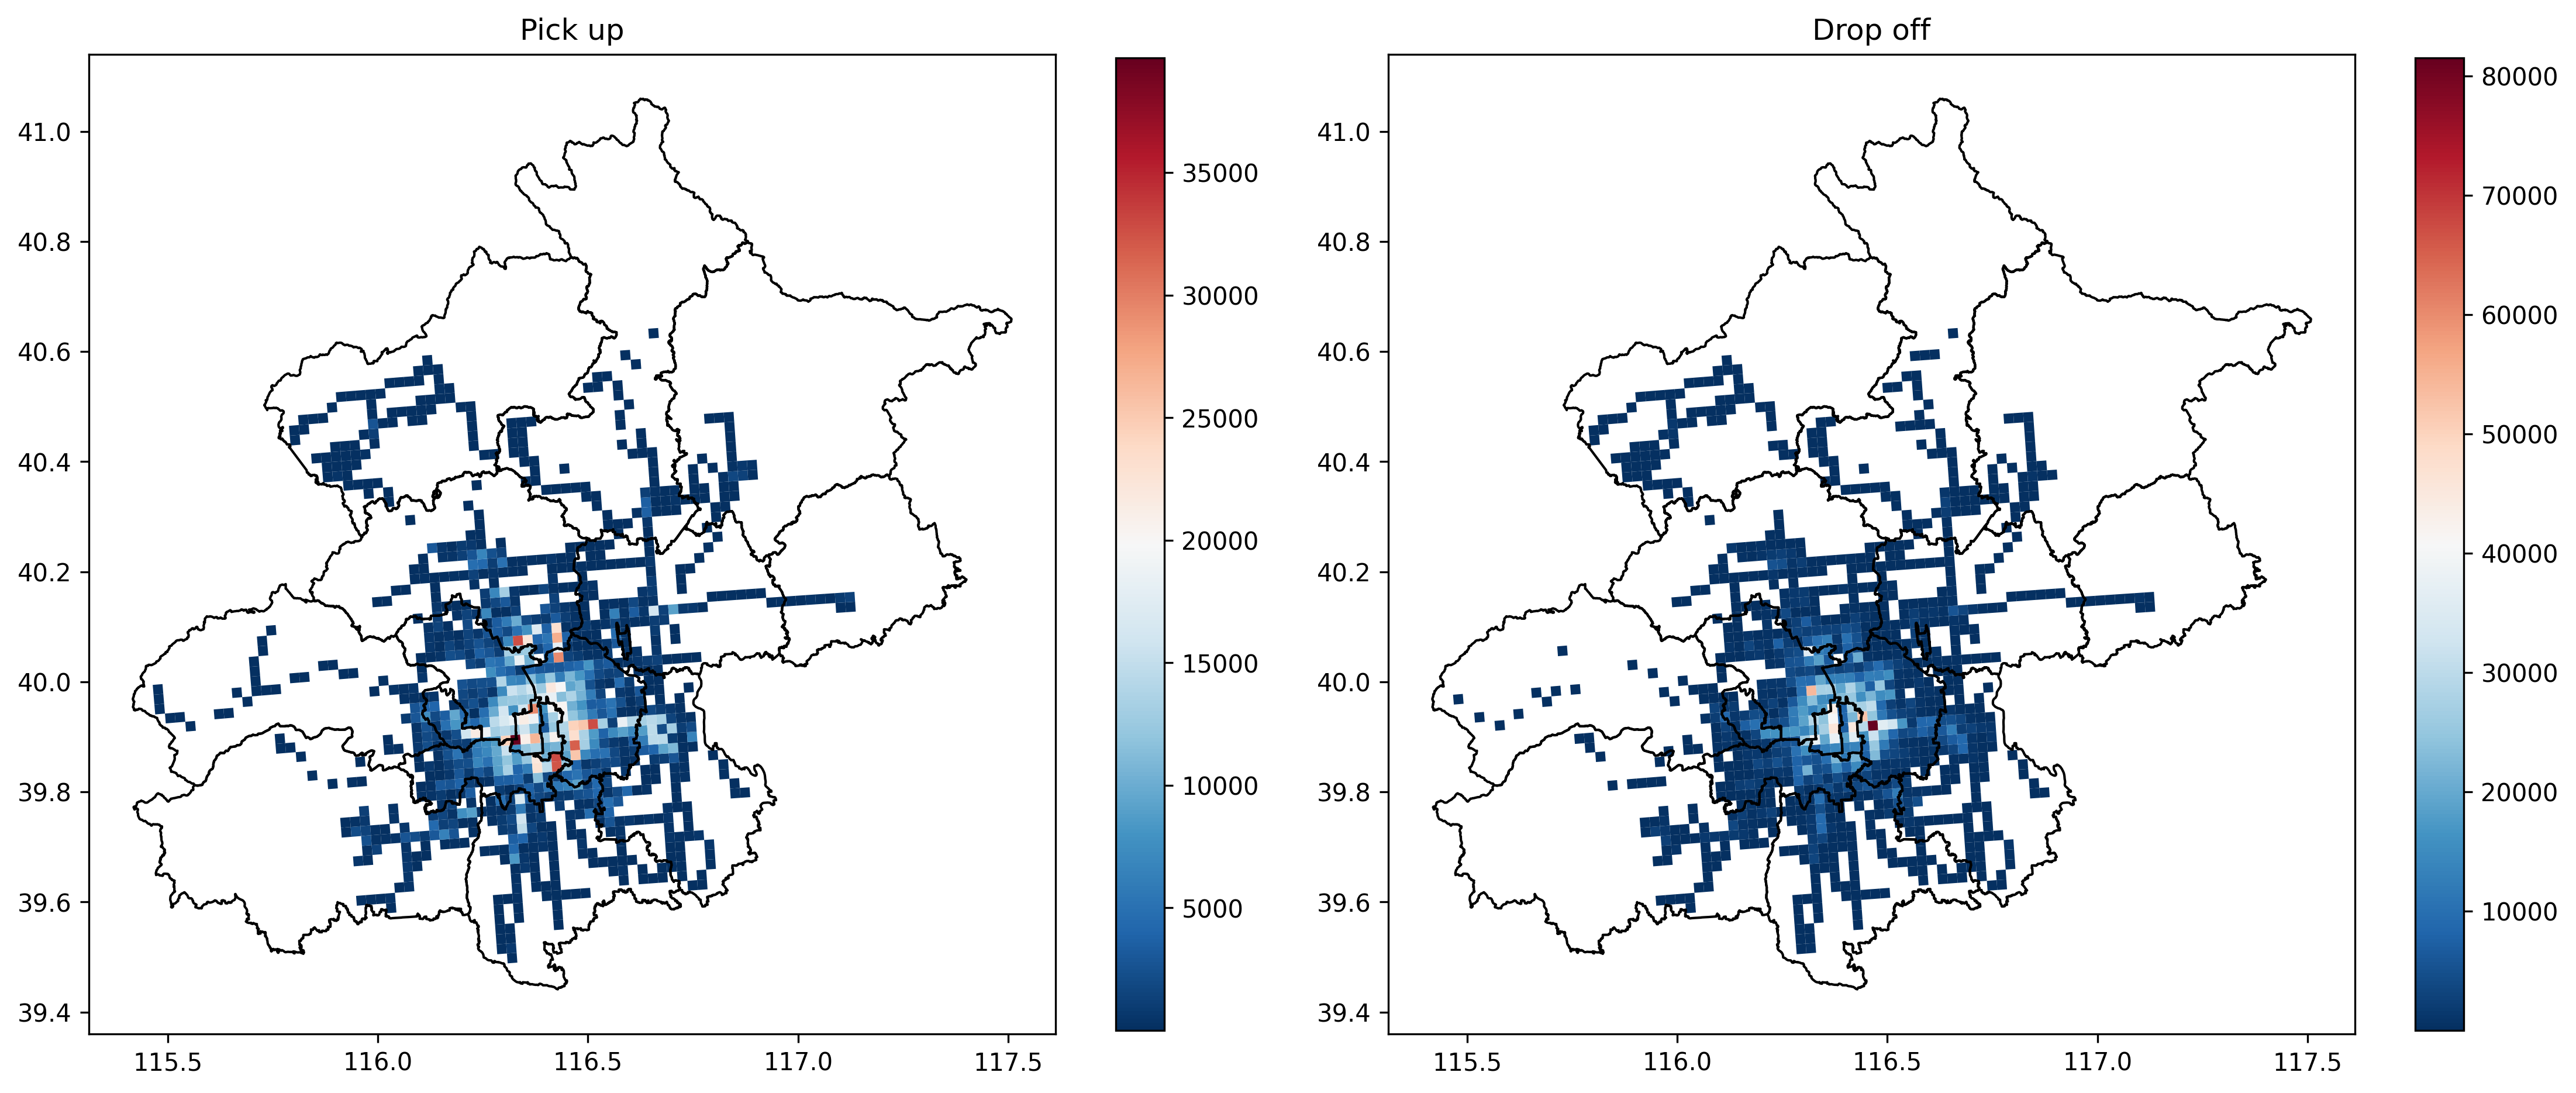

In [30]:
import matplotlib as mpl
fig,ax = plt.subplots(1,2,figsize=(15,8),dpi=300)


# maxval=21000.0
# minval=0

# build up colormap and normalizer
# norm = mpl.colors.LogNorm(vmax=maxval, vmin=minval)

beijnet1.plot(ax=ax[0],column='fsflow',cmap='RdBu_r',legend=True,
             legend_kwds={'orientation':'vertical','shrink':0.72})
beij.plot(ax=ax[0],facecolor='none',edgecolor='k')
ax[0].set_title(f'Pick up')


# build up colormap and normalizer
# norm = mpl.colors.LogNorm(vmax=maxval, vmin=minval)

beijnet2.plot(ax=ax[1],column='xyflow',cmap='RdBu_r',legend=True,
            legend_kwds={'orientation':'vertical','shrink':0.72})
beij.plot(ax=ax[1],facecolor='none',edgecolor='k')
ax[1].set_title(f'Drop off')
fig.tight_layout()
fig.savefig(r'图\flow_distribution_1.png', dpi=400)

In [ ]:
geopanda.merge()

##  3 visulization

In [1]:
import geoplot as gplt
import adjustText as aT 
import mapclassify as mc
from xpinyin import Pinyin 

In [ ]:
fasflow=np.sum(flowadj,axis=1) 
xyflow=np.sum(flowadj,axis=0)  
sts_all=list(dfflowadj.columns)
gests=list(gemmbs['station'])
gefsflow=np.zeros(gemmbs.shape[0])
gexyflow=np.zeros(gemmbs.shape[0])
for i in range(len(sts_all)):
    sts_i=sts_all[i]
    idi=gests.index(sts_i)
    gefsflow[idi]=fasflow[i]
    gexyflow[idi]=xyflow[i]
gemmbs['fsflow']=gefsflow
gemmbs['xyflow']=gexyflow
gemmbs.head()

In [43]:
gemmbs1=gemmbs[gemmbs['fsflow']!=0]
gemmbs2=gemmbs[gemmbs['xyflow']!=0]

In [116]:
beij_points=beij.copy()
beij_points["center"] = beij_points["geometry"].centroid
beij_points.set_geometry("center", inplace=True)
def trans_x(x):
    p = Pinyin()
    re1 = p.get_pinyin(x[:-1])
    re2= re1.split('-')
    re3=''.join(re2).capitalize()
    return re3

beij_points['县1']=beij_points['县'].apply(lambda x:trans_x(x))

font={'family':'serif',
     'style':'italic',
    'weight':'light',
      'color':'gray',
      'size':6
}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [149]:
def trans_x2(x):
    p = Pinyin()
    re1 =p.get_pinyin(x[:-2])
    re2= re1.split('-')
    re3=''.join(re2).capitalize()
    return re3
gemmbs1['Estation']=gemmbs1['station'].apply(lambda x:trans_x2(x))
gemmbs2['Estation']=gemmbs2['station'].apply(lambda x:trans_x2(x))
gemmbs2.head(1)

station         lng        lat                    geometry  fsflow  \
207   西二旗_m  116.312665  40.058928  POINT (116.31266 40.05893)  6356.0   

      xyflow Estation  
207  31529.0   Xierqi

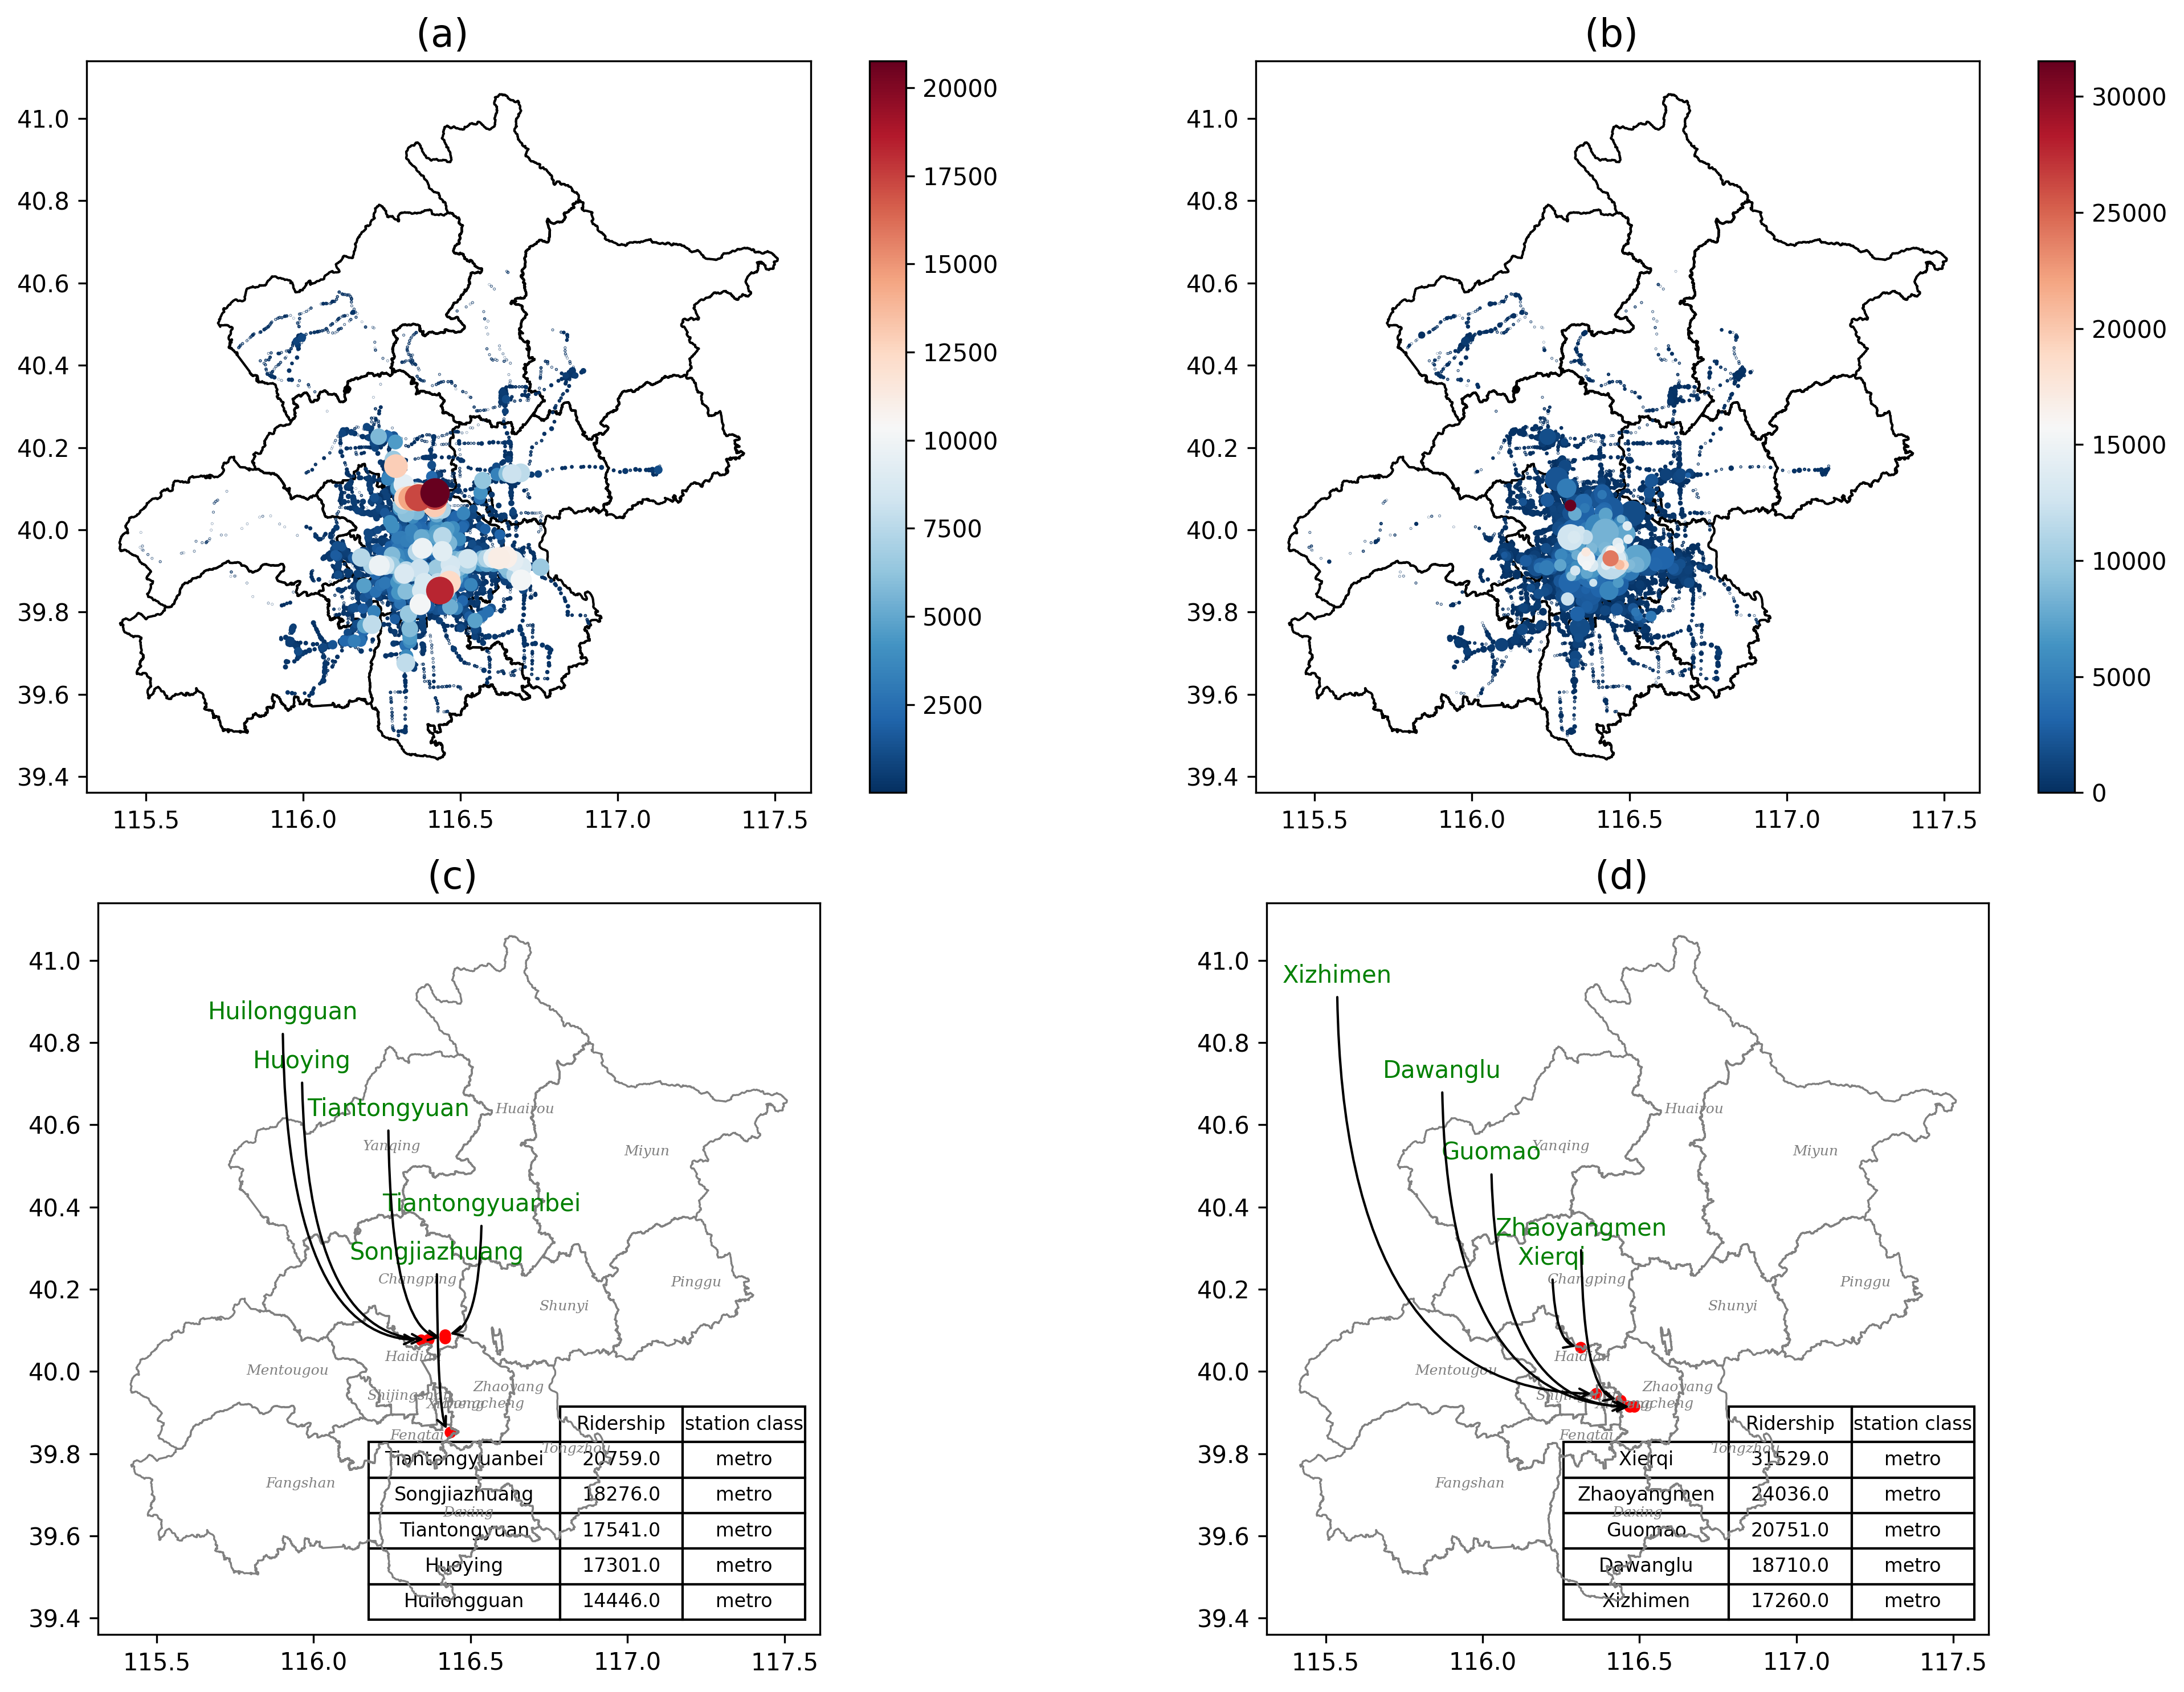

In [317]:
fig,ax = plt.subplots(2,2,figsize=(14,10),dpi=300)

gemmbs1=gemmbs1.sort_values(by=['fsflow'],ascending=True)
gemmbs2=gemmbs1.sort_values(by=['xyflow'],ascending=True)
beij.plot(ax=ax[0][0],facecolor='none',edgecolor='k')
gemmbs1.plot(ax=ax[0][0], marker='.',column='fsflow', cmap='RdBu_r', markersize =gemmbs1['fsflow']/40,legend=True,
            legend_kwds={'orientation':'vertical','shrink':1},alpha=1)
ax[0][0].set_title(f'(a) ',fontsize=16)

beij.plot(ax=ax[0][1],facecolor='none',edgecolor='k')
gemmbs2.plot(ax=ax[0][1], marker='.',column='xyflow', cmap='RdBu_r', markersize =gemmbs1['xyflow']/40,legend=True,
            legend_kwds={'orientation':'vertical','shrink':1},alpha=1)

ax[0][1].set_title(f'(b) ',fontsize=16)

#  排序站点
gemmbs1=gemmbs1.sort_values(by=['fsflow'],ascending=False)
gemmbs2=gemmbs1.sort_values(by=['xyflow'],ascending=False)

gemmbs1[0:5].plot(ax=ax[1][0], marker='.', markersize =60,color='r')
beij.plot(ax=ax[1][0],facecolor='none',edgecolor='gray',linewidth=0.8)

for x, y, label in zip(beij_points.geometry.x, beij_points.geometry.y, beij_points["县1"]):
    texts.append(ax[1][0].text(x, y, label, fontdict=font))
t=0
for x,y,label in zip(gemmbs1[0:5].geometry.x,gemmbs1[0:5].geometry.y,gemmbs1[0:5]['Estation']):
    ax[1][0].annotate(text=label,xy=(x,y),xytext=(x-t-0.2,y+t+0.3),color='g',
                      arrowprops=dict(arrowstyle='->',connectionstyle="angle3"))
    t=t+0.12

    

    
col_labels = ['Ridership','station class']
row_labels = list(gemmbs1[0:5]['Estation'])
fsflow=list(gemmbs1[0:5]['fsflow'])
fssts=list(gemmbs1[0:5]['station'])
fssts1=[]
for i in fssts:
    if i[-1]=='m':
        fssts1.append('metro')
    else:
        fssts1.append('bus')
table_vals1 = [[fsflow[0],fssts1[0]],[fsflow[1],fssts1[1]],[fsflow[2],fssts1[2]],[fsflow[3],fssts1[3]],
              [fsflow[4],fssts1[4]]]
col_colors = ['none','none']
row_colors = ['none','none','none','none','none']
my_table1 = ax[1][0].table(cellText=table_vals1, colWidths=[0.17]*3,
                     rowLabels=row_labels, colLabels=col_labels,
                     rowColours=row_colors, colColours=col_colors,rowLoc="center",cellLoc="center",loc='lower right')
my_table1.auto_set_font_size(False)
my_table1.set_fontsize(8)

    

gemmbs2[0:5].plot(ax=ax[1][1], marker='.', markersize =60,color='r',legend=True)
beij.plot(ax=ax[1][1],facecolor='none',edgecolor='gray',linewidth=0.8)

for x, y, label in zip(beij_points.geometry.x, beij_points.geometry.y, beij_points["县1"]):
    texts.append(ax[1][1].text(x, y, label, fontdict=font))
t=0
for x,y,label in zip(gemmbs2[0:5].geometry.x,gemmbs2[0:5].geometry.y,gemmbs2[0:5]['Estation']):
    ax[1][1].annotate(text=label,xy=(x,y),xytext=(x-t-0.2,y+0.2+t),color='g',
                      arrowprops=dict(arrowstyle='->',connectionstyle="angle3"))
    t=t+0.2

col_labels = ['Ridership','station class']
row_labels = list(gemmbs2[0:5]['Estation'])
xyflow=list(gemmbs2[0:5]['xyflow'])
xysts=list(gemmbs2[0:5]['station'])
xysts1=[]
for i in xysts:
    if i[-1]=='m':
        xysts1.append('metro')
    else:
        xysts1.append('bus')
table_vals = [[xyflow[0],xysts1[0]],[xyflow[1],xysts1[1]],[xyflow[2],xysts1[2]],[xyflow[3],xysts1[3]],
              [xyflow[4],xysts1[4]]]
col_colors = ['none','none']
row_colors = ['none','none','none','none','none']
my_table = ax[1][1].table(cellText=table_vals, colWidths=[0.17]*3,
                     rowLabels=row_labels, colLabels=col_labels,
                     rowColours=row_colors, colColours=col_colors,rowLoc="center",cellLoc="center",loc='lower right')
my_table.auto_set_font_size(False)
my_table.set_fontsize(8)
ax[1][0].set_title(f'(c) ',fontsize=16)
ax[1][1].set_title(f'(d) ',fontsize=16)
fig.tight_layout()


##  4 assessment importance


In [4]:
from scipy.sparse import coo_matrix
import datetime
import pandas as pd
import numpy as np

In [5]:
dfflowadj=pd.read_csv('公交-地铁的客流需求量.csv',encoding='gbk')
dfflowadj.head(1)

霍营北口_b  新苑街_b  建功北里_b  万盛北里_b  莲怡园北路_b  百望山森林公园_b  焦王庄北口_b  小马厂_b  广阳大街_b  \
0     0.0    0.0     0.0     0.0      0.0        0.0      0.0    0.0     0.0   

   天通东苑二区_b  ...  北土城_m  陶然桥_m  郭公庄_m  北京西站_m  马家堡_m  天通苑南_m  临河里_m  张郭庄_m  \
0       0.0  ...    0.0    0.0    0.0     0.0    0.0     0.0    0.0    0.0   

   永定门外_m  化工_m  
0     0.0   0.0  

[1 rows x 7466 columns]

In [6]:
# 获取OD点（存在的）
flowadj=dfflowadj.values
c=coo_matrix(flowadj)
c.row.shape
orgs=[]
dsts=[]
sts=list(dfflowadj.columns)
for i in range(c.row.shape[0]):
    orgs.append(sts[c.row[i]])
    dsts.append(sts[c.col[i]])
xypath=pd.DataFrame()
xypath['org']=orgs
xypath['dst']=dsts
xypath.head()

org          dst
0  霍营北口_b     上坡佳园西门_b
1  霍营北口_b  地铁回龙观东大街站_b
2  霍营北口_b    回龙观公交场站_b
3  霍营北口_b       流星花园_b
4  霍营北口_b     育新小区北口_b

In [7]:
# 读取同线路路径的OD路径
import os
path=pd.DataFrame()
filenames= os.listdir(r'path\\path_all\\')
t=0
for file in filenames:
    if file not in ['path_all']:
#         print(1)
        data=open(r'path\\path_all\\'+file)
        if data.read()!="\n":
            if '最终路径8' not in file:
#             print(2)
                df1=pd.read_csv(r'path\\path_all\\'+file,encoding='gbk')
                print(df1.shape)
                path=pd.concat([path,df1])
path.shape

(115462, 4)
(3391, 4)
(3433, 4)
(61740, 4)
(19, 4)
(14403, 4)
(744, 4)


(199192, 4)

In [8]:
def split_x(x):
    return x.replace('[','').replace(']','').replace(' ','').replace("'",'').replace(' ','').replace('"','').split(',')
path['path']=path['path'].apply(lambda x:split_x(x))

In [10]:
# 筛选异线OD
print(xypath.shape)
xypath1=xypath.merge(path,on=['org','dst'],how='inner')
print(xypath1.shape)
xypath1.head()

(290768, 2)
(118609, 4)


org      dst                                               path  \
0  新苑街_b    魏公村_b  [新苑街_b, 白石桥南_b, 白石桥北_b, 国家图书馆_b, 中央民族大学_b, 魏公村_b]   
1  新苑街_b    魏公村_b  [新苑街_b, 白石桥南_b, 白石桥北_b, 国家图书馆_b, 中央民族大学_b, 魏公村_b]   
2  新苑街_b  车道沟桥东_b                    [新苑街_b, 白石桥西_b, 北洼路_b, 车道沟桥东_b]   
3  新苑街_b  车道沟桥东_b     [新苑街_b, 白石桥西_b, 北洼路_b, 车道沟桥东_b, 板井_b, 四季青桥东_b]   
4  新苑街_b   白石桥南_b                                    [新苑街_b, 白石桥南_b]   

        time  
0  48.950000  
1  52.800000  
2  47.558333  
3  53.550000  
4  32.225000

In [11]:
xypath1[['org','dst']].drop_duplicates().shape

(49473, 2)

In [ ]:
orgs=list(xypath['org'])
dsts=list(xypath['dst'])
new_org=[]
new_dst=[]
for i in range(len(orgs)):
    org_i=orgs[i]
    dst_i=dsts[i]
    if xypath1[(xypath1['org']==org_i)&(xypath1['dst']==dst_i)].shape[0]==0:
        new_org.append(org_i)
        new_dst.append(dst_i)
xypath3=pd.DataFrame()
xypath3['org']=new_org
xypath3['dst']=new_dst
xypath3.head()

In [310]:
xypath3=pd.DataFrame()
xypath3['org']=new_org
xypath3['dst']=new_dst
xypath3.head()

org          dst
0  霍营北口_b     上坡佳园西门_b
1  霍营北口_b  地铁回龙观东大街站_b
2  霍营北口_b    回龙观公交场站_b
3  霍营北口_b       流星花园_b
4  霍营北口_b     育新小区北口_b

In [ ]:
'''
    将xypath3转pycharm,获取异线路径OD的路径
    step4_6_4_test13.py
'''
xypath3.to_csv('异线路径OD.csv',encoding='gbk',index=False)

In [12]:
'''
    读入异线路径OD的路径 "最终路径8_10.csv"--"最终路径8_0.csv"
    step4_6_4_test13.py
'''
xypath4=pd.DataFrame()
filenames= os.listdir(r'path\\path_all\\')
t=0
for file in filenames:
    if file not in ['path_all']:
#         print(1)
        data=open(r'path\\path_all\\'+file)
        if data.read()!="\n":
            if '最终路径8' in file:
#                 print(file)
                dfxy=pd.read_csv(r'path\\path_all\\'+file,encoding='gbk')
#                 print(dfxy.shape)
                xypath4=pd.concat([xypath4,dfxy])
xypath4=xypath4.drop_duplicates()
print(xypath4.shape)

(326871, 4)


In [13]:
def split_x(x):
    return x.replace('[','').replace(']','').replace(' ','').replace("'",'').replace("'",'').split(',')

In [14]:
xypath4['path']=xypath4['path'].apply(lambda x:split_x(x))
xypath4.head(1)

org      dst                                               path  \
0  春秀路_b  和平里北街_b  [春秀路_b, 幸福三村_b, 亮马桥_b, 燕莎桥南_b, 燕莎桥东_b, 亮马桥_m, ...   

         time  
0  174.756465

In [21]:
xypath5=pd.concat([xypath1,xypath4])
print(xypath5.shape)
xypath5.head(1)

(445480, 4)


org    dst                                               path   time
0  新苑街_b  魏公村_b  [新苑街_b, 白石桥南_b, 白石桥北_b, 国家图书馆_b, 中央民族大学_b, 魏公村_b]  48.95

In [40]:

xy1=xypath5[['org','dst']].drop_duplicates()
xy1['in']=1
df1=xypath.merge(xy1,on=['org','dst'],how='outer')
df1=df1.fillna(0)

xypath6=df1[df1['in']==0][['org','dst']]
xypath6=xypath.reset_index()
xypath6=xypath6.drop(columns='index')
xypath6.head()

org          dst
0  霍营北口_b     上坡佳园西门_b
1  霍营北口_b  地铁回龙观东大街站_b
2  霍营北口_b    回龙观公交场站_b
3  霍营北口_b       流星花园_b
4  霍营北口_b     育新小区北口_b

In [357]:

orgs=list(xypath['org'])
dsts=list(xypath['dst'])
new_org=[]
new_dst=[]
for i in range(len(orgs)):
    org_i=orgs[i]
    dst_i=dsts[i]
    if xypath5[(xypath5['org']==org_i)&(xypath5['dst']==dst_i)].shape[0]==0:
        new_org.append(org_i)
        new_dst.append(dst_i)
xypath6=pd.DataFrame()
xypath6['org']=new_org
xypath6['dst']=new_dst
xypath6.head()

org          dst
0  霍营北口_b     上坡佳园西门_b
1  霍营北口_b  地铁回龙观东大街站_b
2  霍营北口_b    回龙观公交场站_b
3  霍营北口_b       流星花园_b
4  霍营北口_b     育新小区北口_b

###  4.4.1 networkx尝试

        nx.algorithms.all_pairs_bellman_ford_path
        nx.algorithms.all_pairs_dijkstra_path
        nx.algorithms.all_pairs_shortest_path
        nx.algorithms.all_shortest_paths
        nx.algorithms.astar_path
        #
        dijkstra_path
        flow_matrix
        multi_source_dijkstra_path
        shortest_paths
        shortest_simple_paths
        all_shortest_paths
        all_pairs_shortest_path
        astar_path


In [16]:
import networkx as nx
from scipy.sparse import coo_matrix
import geopandas as gpd
from shapely import geometry
from matplotlib import pyplot as plt

In [17]:
dfmmbsadj=pd.read_csv('公交-地铁邻接矩阵(双向).csv',encoding='gbk')
dfdxmmbsadj=pd.read_csv('公交-地铁邻接矩阵(单向).csv',encoding='gbk')
wadj = pd.read_csv('公交-地铁时间加权矩阵.csv', encoding='gbk')
wadj.index = list(wadj['Unnamed: 0'])
wadj = wadj.drop(columns='Unnamed: 0')

In [18]:
# 创建加权邻接矩阵
c2=coo_matrix(dfmmbsadj.values)
wadj=wadj[list(dfmmbsadj.columns)].loc[list(dfmmbsadj.columns)] # 按照dfdxmmadj的index和columns进行排序
c1=coo_matrix(wadj.values)
stc=list(dfmmbsadj.columns)
awadj=wadj.values
for i in range(c2.row.shape[0]):
    if awadj[c2.row[i],c2.col[i]]==0:
        si1=stc[c2.row[i]]
        si2=stc[c2.col[i]]
        if si1[-1]==si2[-1] and si1[-1]=='m':
            awadj[c2.row[i],c2.col[i]]=5.5
        if si1[-1]==si2[-1] and si1[-1]=='b':
            awadj[c2.row[i],c2.col[i]]=np.round(np.random.random()*4+10,2)
        if si1[-1]!=si2[-1]:
            awadj[c2.row[i],c2.col[i]]=np.round(np.random.random()*10+5,2)
dxwadj=awadj*dfdxmmbsadj.values
dfdxwadj=pd.DataFrame(dxwadj)
dfdxwadj.columns=dfdxmmbsadj.columns
dfwadj=pd.DataFrame(awadj*dfmmbsadj.values)
dfwadj.columns=dfmmbsadj.columns
# 验证
c3=coo_matrix(dfwadj.values)
print(c3.row.shape[0]==c2.row.shape[0])
c4=coo_matrix(dfdxwadj.values)
c5=coo_matrix(dfdxmmbsadj.values)
print(c4.row.shape[0]==c5.row.shape[0])

True
True


In [19]:
# 创建加权networkx
# 地铁站点
dfdxmmbsadj.index=dfdxmmbsadj.columns
dfmmbsadj.index=dfmmbsadj.columns
df4=pd.read_csv('数据处理\地铁站点.csv',encoding='gbk')
df4=df4.drop(columns='Unnamed: 0')
def split_x32(x):
    return x+'_m'
df4['station']=df4['station'].apply(lambda x:split_x32(x))
# 公交站点
df3=pd.read_csv('数据处理\公交站点.csv',encoding='gbk')
df3=df3.drop(columns='Unnamed: 0')
def split_x22(x):
    return x+'_b'
df3['station']=df3['station'].apply(lambda x:split_x22(x))
# 创建节点属性 pos
df5=pd.concat([df3,df4])
gemmbs = gpd.GeoDataFrame(df5[['station','lng','lat']],
                          geometry=gpd.points_from_xy(df5['lng'],df5['lat'],crs='epsg:4326'))
gemmbs1=gemmbs.copy()
gemmbs1=gemmbs1.to_crs('epsg:32651')
# 创建无向 networkx
sts=list(dfmmbsadj.columns)
mmbs=coo_matrix(dfmmbsadj.values)
# networkx
mmbsG = nx.Graph()
mmbsD=dfdxmmbsadj.values
mmbsc=coo_matrix(mmbsD)

mmbsedges=[(mmbsc.row[i],mmbsc.col[i]) for i in range(mmbsc.row.shape[0])]
mmbsG.add_edges_from(mmbsedges)

mmbsrws=list(dfdxmmbsadj.index)
mmbsattrs ={i:{'pos':[gemmbs1[gemmbs1['station']==mmbsrws[i]]['geometry'].x.values[0],
           gemmbs1[gemmbs1['station']==mmbsrws[i]]['geometry'].y.values[0]],
               'name':mmbsrws[i]} for i in range(len(list(mmbsG.nodes)))}
awadj=dfwadj.values
idi=list(mmbsG.nodes)
mmbsedgattr={(mmbsc.row[i],mmbsc.col[i]):{'weight':awadj[mmbsc.row[i],mmbsc.col[i]],
                                      'start':sts[mmbsc.row[i]],
                                      'end':sts[mmbsc.col[i]]} 
             for i in range(mmbsc.row.shape[0])}
nx.set_node_attributes(mmbsG, mmbsattrs)
nx.set_edge_attributes(mmbsG, mmbsedgattr)

In [463]:

we=nx.get_edge_attributes(mmbsG,'weight')

with open("C:/Users/111/Desktop/k-shortest-paths-cpp-version-master/data/test_7466_1","w") as f:
    f.write('%s\n'%(len(list(mmbsG.nodes()))))
    f.write('\n')
    for key,value in zip(we.keys(),we.values()):
        edw=str(key[0])+" "+str(key[1])+" "+str(value)
        f.write('%s\n'%(edw))
        edw1=str(key[1])+" "+str(key[0])+" "+str(value)
        f.write('%s\n'%(edw1))
    f.write('\n')
f.close()

In [477]:

nas=nx.get_node_attributes(mmbsG,'name')
nas=pd.DataFrame(nas.items())
nas.columns=['index','name']
with open("C:/Users/111/Desktop/k-shortest-paths-cpp-version-master/data/odlist.txt","w") as f:
    for i in range(xypath6.shape[0]):
        id1=nas[nas['name']==xypath6.iloc[i,0]]['index'].to_list()[0]
        id2=nas[nas['name']==xypath6.iloc[i,1]]['index'].to_list()[0]
        edw=str(id1)+" "+str(id2)
        f.write('%s\n'%(edw))
    f.write('\n')
f.close()

In [42]:
nas=nx.get_node_attributes(mmbsG,'name')
nas=pd.DataFrame(nas.items())
nas.columns=['index','name']

In [ ]:

pall=[]
tall=[]
for i in range(xypath6.shape[0]):
    orgi=xypath6.iloc[i,0]
    dsti=xypath6.iloc[i,1]
    id1=nas[nas['name']==xypath6.iloc[i,0]]['index'].to_list()[0]
    id2=nas[nas['name']==xypath6.iloc[i,1]]['index'].to_list()[0]
    pi=[p for p in nx.algorithms.all_shortest_paths(mmbsG, source=id1, target=id2,weight='weight')]
    if len(pi)!=0:
        if len(pi)==1:
            pall.append(pi[0])
            ti=nx.algorithms.shortest_path_length(mmbsG, source=id1, target=id2,weight='weight')
            tall.append(ti)
        else:
            pall.append(pi)
            tall.append([ti]*len(pi))
            print([id2,id2])
xypath6['path']=pall

In [44]:
xypath6['time']=tall
xypath6.head()

org          dst                                              path  \
0  霍营北口_b     上坡佳园西门_b                                 [3424, 7436, 584]   
1  霍营北口_b  地铁回龙观东大街站_b                           [3424, 7436, 584, 5955]   
2  霍营北口_b    回龙观公交场站_b           [3424, 7436, 7207, 7193, 199, 3427, 71]   
3  霍营北口_b       流星花园_b                     [3424, 7436, 7207, 7193, 199]   
4  霍营北口_b     育新小区北口_b  [3424, 7436, 7209, 7447, 5293, 6599, 1604, 4311]   

        time  
0  13.903614  
1  20.503614  
2  39.300201  
3  28.858534  
4  45.210161

In [45]:
new_path=[]
for i in range(xypath6.shape[0]):
    ti=xypath6.iloc[i,3]
    orgi=xypath6.iloc[i,0]
    dsti=xypath6.iloc[i,1]
    pathi=xypath6.iloc[i,2]
    try:
        if len(ti)>1:
            [new_path.append([orgi,dsti,pathi[c],ti[c]]) for c in range(len(ti))]
    except:
        new_path.append([orgi,dsti,pathi,ti])

In [46]:
xypath7=pd.DataFrame(new_path)
xypath7.columns=xypath5.columns
xypath7.head(1)

org       dst               path       time
0  霍营北口_b  上坡佳园西门_b  [3424, 7436, 584]  13.903614

In [55]:
# 验证是否获取所有OD路径
xypath7[['org','dst']].drop_duplicates().shape[0]==xypath.shape[0]

True

In [56]:
xypath5[['org','dst']].drop_duplicates().shape[0]

75485

In [57]:
xypath7[['org','dst']].drop_duplicates().shape[0]

290768

In [58]:
# 路径合并
xypath8=pd.concat([xypath7,xypath5])
xypath8.shape

(737197, 4)

In [90]:
xypath8[['org','dst']].drop_duplicates().shape

(290768, 2)

In [107]:
# 将路径进行保存
nas=nx.get_node_attributes(mmbsG,'name')
nas=pd.DataFrame(nas.items())
nas.columns=['index','name']
def convert_x(x):
    if len(x)!=0:
        try:
            if len(x[0])!=0:
                df1=pd.DataFrame()
                df1['name']=x
                df2=df1.merge(nas,on='name',how='inner')
                if df1.shape[0]==df2.shape[0]:
                    x=list(df2['index'])
        except:
            x=x
    else:
        x=-1
    return x
xypath8['path_new']=xypath8['path'].apply(lambda x:convert_x(x))
xypath8.head()

org          dst                                              path  \
0  霍营北口_b     上坡佳园西门_b                                 [3424, 7436, 584]   
1  霍营北口_b  地铁回龙观东大街站_b                           [3424, 7436, 584, 5955]   
2  霍营北口_b    回龙观公交场站_b           [3424, 7436, 7207, 7193, 199, 3427, 71]   
3  霍营北口_b       流星花园_b                     [3424, 7436, 7207, 7193, 199]   
4  霍营北口_b     育新小区北口_b  [3424, 7436, 7209, 7447, 5293, 6599, 1604, 4311]   

        time                                          path_new  
0  13.903614                                 [3424, 7436, 584]  
1  20.503614                           [3424, 7436, 584, 5955]  
2  39.300201           [3424, 7436, 7207, 7193, 199, 3427, 71]  
3  28.858534                     [3424, 7436, 7207, 7193, 199]  
4  45.210161  [3424, 7436, 7209, 7447, 5293, 6599, 1604, 4311]

In [108]:
xypath8=xypath8[['org','dst','path_new','time']]
xypath8=xypath8.rename(columns={'path_new':'path'})
xypath8.head()

org          dst                                              path  \
0  霍营北口_b     上坡佳园西门_b                                 [3424, 7436, 584]   
1  霍营北口_b  地铁回龙观东大街站_b                           [3424, 7436, 584, 5955]   
2  霍营北口_b    回龙观公交场站_b           [3424, 7436, 7207, 7193, 199, 3427, 71]   
3  霍营北口_b       流星花园_b                     [3424, 7436, 7207, 7193, 199]   
4  霍营北口_b     育新小区北口_b  [3424, 7436, 7209, 7447, 5293, 6599, 1604, 4311]   

        time  
0  13.903614  
1  20.503614  
2  39.300201  
3  28.858534  
4  45.210161

In [112]:
xypath8=xypath8.reset_index()
xypath8=xypath8.drop(columns='index')

In [113]:
xypath8.to_feather('公交-地铁的出行路径.feather')

In [527]:
dfflowadj.head(1)

霍营北口_b  新苑街_b  建功北里_b  万盛北里_b  莲怡园北路_b  百望山森林公园_b  焦王庄北口_b  小马厂_b  广阳大街_b  \
0     0.0    0.0     0.0     0.0      0.0        0.0      0.0    0.0     0.0   

   天通东苑二区_b  ...  北土城_m  陶然桥_m  郭公庄_m  北京西站_m  马家堡_m  天通苑南_m  临河里_m  张郭庄_m  \
0       0.0  ...    0.0    0.0    0.0     0.0    0.0     0.0    0.0    0.0   

   永定门外_m  化工_m  
0     0.0   0.0  

[1 rows x 7466 columns]

In [59]:
xypath8.head()

org          dst                                              path  \
0  霍营北口_b     上坡佳园西门_b                                 [3424, 7436, 584]   
1  霍营北口_b  地铁回龙观东大街站_b                           [3424, 7436, 584, 5955]   
2  霍营北口_b    回龙观公交场站_b           [3424, 7436, 7207, 7193, 199, 3427, 71]   
3  霍营北口_b       流星花园_b                     [3424, 7436, 7207, 7193, 199]   
4  霍营北口_b     育新小区北口_b  [3424, 7436, 7209, 7447, 5293, 6599, 1604, 4311]   

        time  
0  13.903614  
1  20.503614  
2  39.300201  
3  28.858534  
4  45.210161

In [ ]:
# 计算OD对路径的综合平均时间---logit
flowadj=dfflowadj.values
c=coo_matrix(flowadj)
sts=list(dfflowadj.columns)
odall=[]
for i in range(c.row.shape[0]):
    orgi=sts[c.row[i]]
    dsti=sts[c.col[i]]
    flowi=c.data[i]
    time_list=xypath8[(xypath8['org']==orgi)&(xypath8['dst']==dsti)]['time'].to_list()
    exptime=[np.exp(-c) for c in time_list]
    pijkt=[c/sum(exptime) for c in exptime]
    ctime=np.sum(np.array(time_list)*np.array(pijkt))
    odall.append([orgi,dsti,flowi,ctime])
dfod=pd.DataFrame(odall)
dfod.columns=[['org','dst','flow','time']]
dfod.head()

In [62]:
newod=pd.DataFrame(dfod.values)
newod.columns=['org','dst','flow','time']

In [622]:
# 构建重力模型的各变量的联系
ilt=[]
sall=[]
for i in range(newod.shape[0]):
    if i not in ilt:
        org1=newod.iloc[i,0]
        dst1=newod.iloc[i,1]
        if newod[(newod['org']==dst1)&(newod['dst']==org1)].shape[0]!=0:
            ilti=newod[(newod['org']==dst1)&(newod['dst']==org1)].index[0]
            ilt.append(ilti)
            flowi=newod[(newod['org']==dst1)&(newod['dst']==org1)]['flow'].to_list()[0]
            timei=newod[(newod['org']==dst1)&(newod['dst']==org1)]['time'].to_list()[0]
            sall.append([org1,dst1,newod.iloc[i,2],newod.iloc[i,3],dst1,org1,flowi,timei])
fsxy=pd.DataFrame(sall)
fsxy.columns=['org1','dst1','flow1','time1','org2','dst2','flow2','time2']
fsxy.head()

org1         dst1  flow1      time1         org2    dst2  flow2  \
0  霍营北口_b     上坡佳园西门_b    2.0  13.903614     上坡佳园西门_b  霍营北口_b   13.0   
1  霍营北口_b  地铁回龙观东大街站_b    9.0  20.503614  地铁回龙观东大街站_b  霍营北口_b    6.0   
2  霍营北口_b    回龙观公交场站_b    2.0  39.300201    回龙观公交场站_b  霍营北口_b    1.0   
3  霍营北口_b     育新小区北口_b    1.0  46.840161     育新小区北口_b  霍营北口_b    7.0   
4  霍营北口_b     地铁霍营站东_b    7.0  25.372189     地铁霍营站东_b  霍营北口_b    7.0   

       time2  
0  13.903614  
1  20.503614  
2  39.300201  
3  46.840161  
4  25.372189

In [631]:
# 进行节点重要度评价
fsxy['im_ij']=np.array(fsxy['flow1'])*np.array(fsxy['flow2'])/np.array(fsxy['time1'])
fsxy.head()

org1         dst1  flow1      time1         org2    dst2  flow2  \
0  霍营北口_b     上坡佳园西门_b    2.0  13.903614     上坡佳园西门_b  霍营北口_b   13.0   
1  霍营北口_b  地铁回龙观东大街站_b    9.0  20.503614  地铁回龙观东大街站_b  霍营北口_b    6.0   
2  霍营北口_b    回龙观公交场站_b    2.0  39.300201    回龙观公交场站_b  霍营北口_b    1.0   
3  霍营北口_b     育新小区北口_b    1.0  46.840161     育新小区北口_b  霍营北口_b    7.0   
4  霍营北口_b     地铁霍营站东_b    7.0  25.372189     地铁霍营站东_b  霍营北口_b    7.0   

       time2     im_ij  
0  13.903614  1.870017  
1  20.503614  2.633682  
2  39.300201  0.050890  
3  46.840161  0.149444  
4  25.372189  1.931248

In [672]:
# 得到站点的功能性重要评价结果
sts_im=list(set(list(fsxy['org1'])))
imv=[]
for i in sts_im:
    imv.append(np.sum(np.array(fsxy[fsxy['org1']==i]['im_ij'])))
F=pd.DataFrame()
F['station']=sts_im
F['imv']=np.array(imv)/sum(imv)
print(F.shape)
F.head()

(4870, 2)


station           imv
0     朝阳路高井_b  1.162290e-03
1  北京师范大学南门_b  5.360330e-05
2       骚子营_b  6.130379e-04
3       于家务_b  6.671313e-07
4      燕莎桥北_b  6.521994e-07

In [673]:
F=F.sort_values(by='imv',ascending=False)

In [665]:
F1=pd.DataFrame()
F1['station']=list(dfmmbsadj.columns)
F1['imv']=np.sum(dfmmbsadj.values,axis=1)/np.sum(np.sum(dfmmbsadj.values))
F1=F1.sort_values(by='imv',ascending=False)
F2=F1.merge(F,on='station',how='outer')
F2=F2.fillna(0)
F3=F2[F2['imv_y']==0][['station','imv_x']]
F3=F3.rename(columns={'imv_x':'imv'})
F4=pd.concat([F,F3])
F4['imv']=np.array(F4['imv'])/sum(list(F4['imv']))
F4.sort_values(by='imv',ascending=False).head(10)

station       imv
0  黄村火车站_b  0.000127

In [689]:
F4.sort_values(by='imv',ascending=False).head(10)

station       imv
281      西二旗_m  0.025977
1349  北苑家园西站_b  0.010330
2405    六里桥东_b  0.008717
3920     十里河_m  0.007871
3999     大望路_m  0.007542
4472     五道口_m  0.007272
3697     三元桥_m  0.007201
2622     崇文门_m  0.006810
2887      上地_m  0.006572
455       双井_m  0.006542

In [690]:
F4.to_csv('公交-地铁功能重要度.csv',encoding='gbk',index=False)

In [692]:
F4.shape

(7466, 2)

#  5 Fig

In [633]:
S=pd.read_csv('公交-地铁结构重要度.csv',encoding='gbk')
POI=pd.read_csv('公交-地铁POI类权重.csv',encoding='gbk')
print(S.shape)
print(POI.shape)

(7466, 2)
(7466, 3)


In [638]:
POI=POI.drop(columns=['Unnamed: 0'])
POI=POI.rename(columns={'index':'station'})
POI.head(1)

station         POI_W
0  长流水_buss  6.281669e-07

In [647]:
def split_x(x):
    if x[-1]=='s':
        x1=x[:-5]+'_b'
    else:
        x1=x[:-6]+'_m'
    return x1
POI['station']=POI['station'].apply(lambda x:split_x(x))
POI.head(1)

station         POI_W
0   长流水_b  6.281669e-07

In [648]:
ima=S.merge(POI,on='station',how='inner')
ima.head()

station  strucutre_importance         POI_W
0     黄村火车站_b              0.000024  1.277509e-04
1       清华园_b              0.000544  5.657014e-04
2     北车营七队_b              0.000267  6.281669e-07
3  小沙河村公交场站_b              0.000000  6.281669e-07
4    北辰福第小区_b              0.000059  3.612798e-05

In [695]:
ima1=ima.merge(F4,on='station',how='inner')
ima1.head()

station  strucutre_importance         POI_W           imv
0     黄村火车站_b              0.000024  1.277509e-04  1.479676e-04
1       清华园_b              0.000544  5.657014e-04  2.098201e-04
2     北车营七队_b              0.000267  6.281669e-07  6.776675e-05
3  小沙河村公交场站_b              0.000000  6.281669e-07  4.039993e-07
4    北辰福第小区_b              0.000059  3.612798e-05  4.025480e-05

In [698]:
ima1['strucutre_importance']=np.array(ima1['strucutre_importance'])/sum(list(ima1['strucutre_importance']))

In [700]:
comim=np.array(ima1['strucutre_importance'])+np.array(ima1['POI_W'])+np.array(ima1['imv'])
ima1['com_im']=comim/sum(comim)
ima1.head()

station  strucutre_importance         POI_W           imv        com_im
0     黄村火车站_b          9.357221e-07  1.277509e-04  1.479676e-04  9.221808e-05
1       清华园_b          2.148650e-05  5.657014e-04  2.098201e-04  2.656693e-04
2     北车营七队_b          1.053393e-05  6.281669e-07  6.776675e-05  2.630962e-05
3  小沙河村公交场站_b          0.000000e+00  6.281669e-07  4.039993e-07  3.440554e-07
4    北辰福第小区_b          2.335259e-06  3.612798e-05  4.025480e-05  2.623934e-05

<AxesSubplot:>

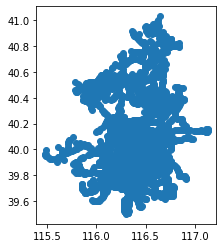

In [701]:
gemmbs.plot()

In [703]:
gemmbs.shape

(7466, 4)

In [704]:
gemmbs1=gemmbs.merge(ima1,on='station',how='inner')
gemmbs1.shape

(7466, 8)

In [705]:
gemmbs1.head(1)

station        lng       lat                    geometry  \
0  霍营北口_b  116.36554  40.08844  POINT (116.36554 40.08844)   

   strucutre_importance     POI_W       imv    com_im  
0              0.000046  0.000017  0.000029  0.000031

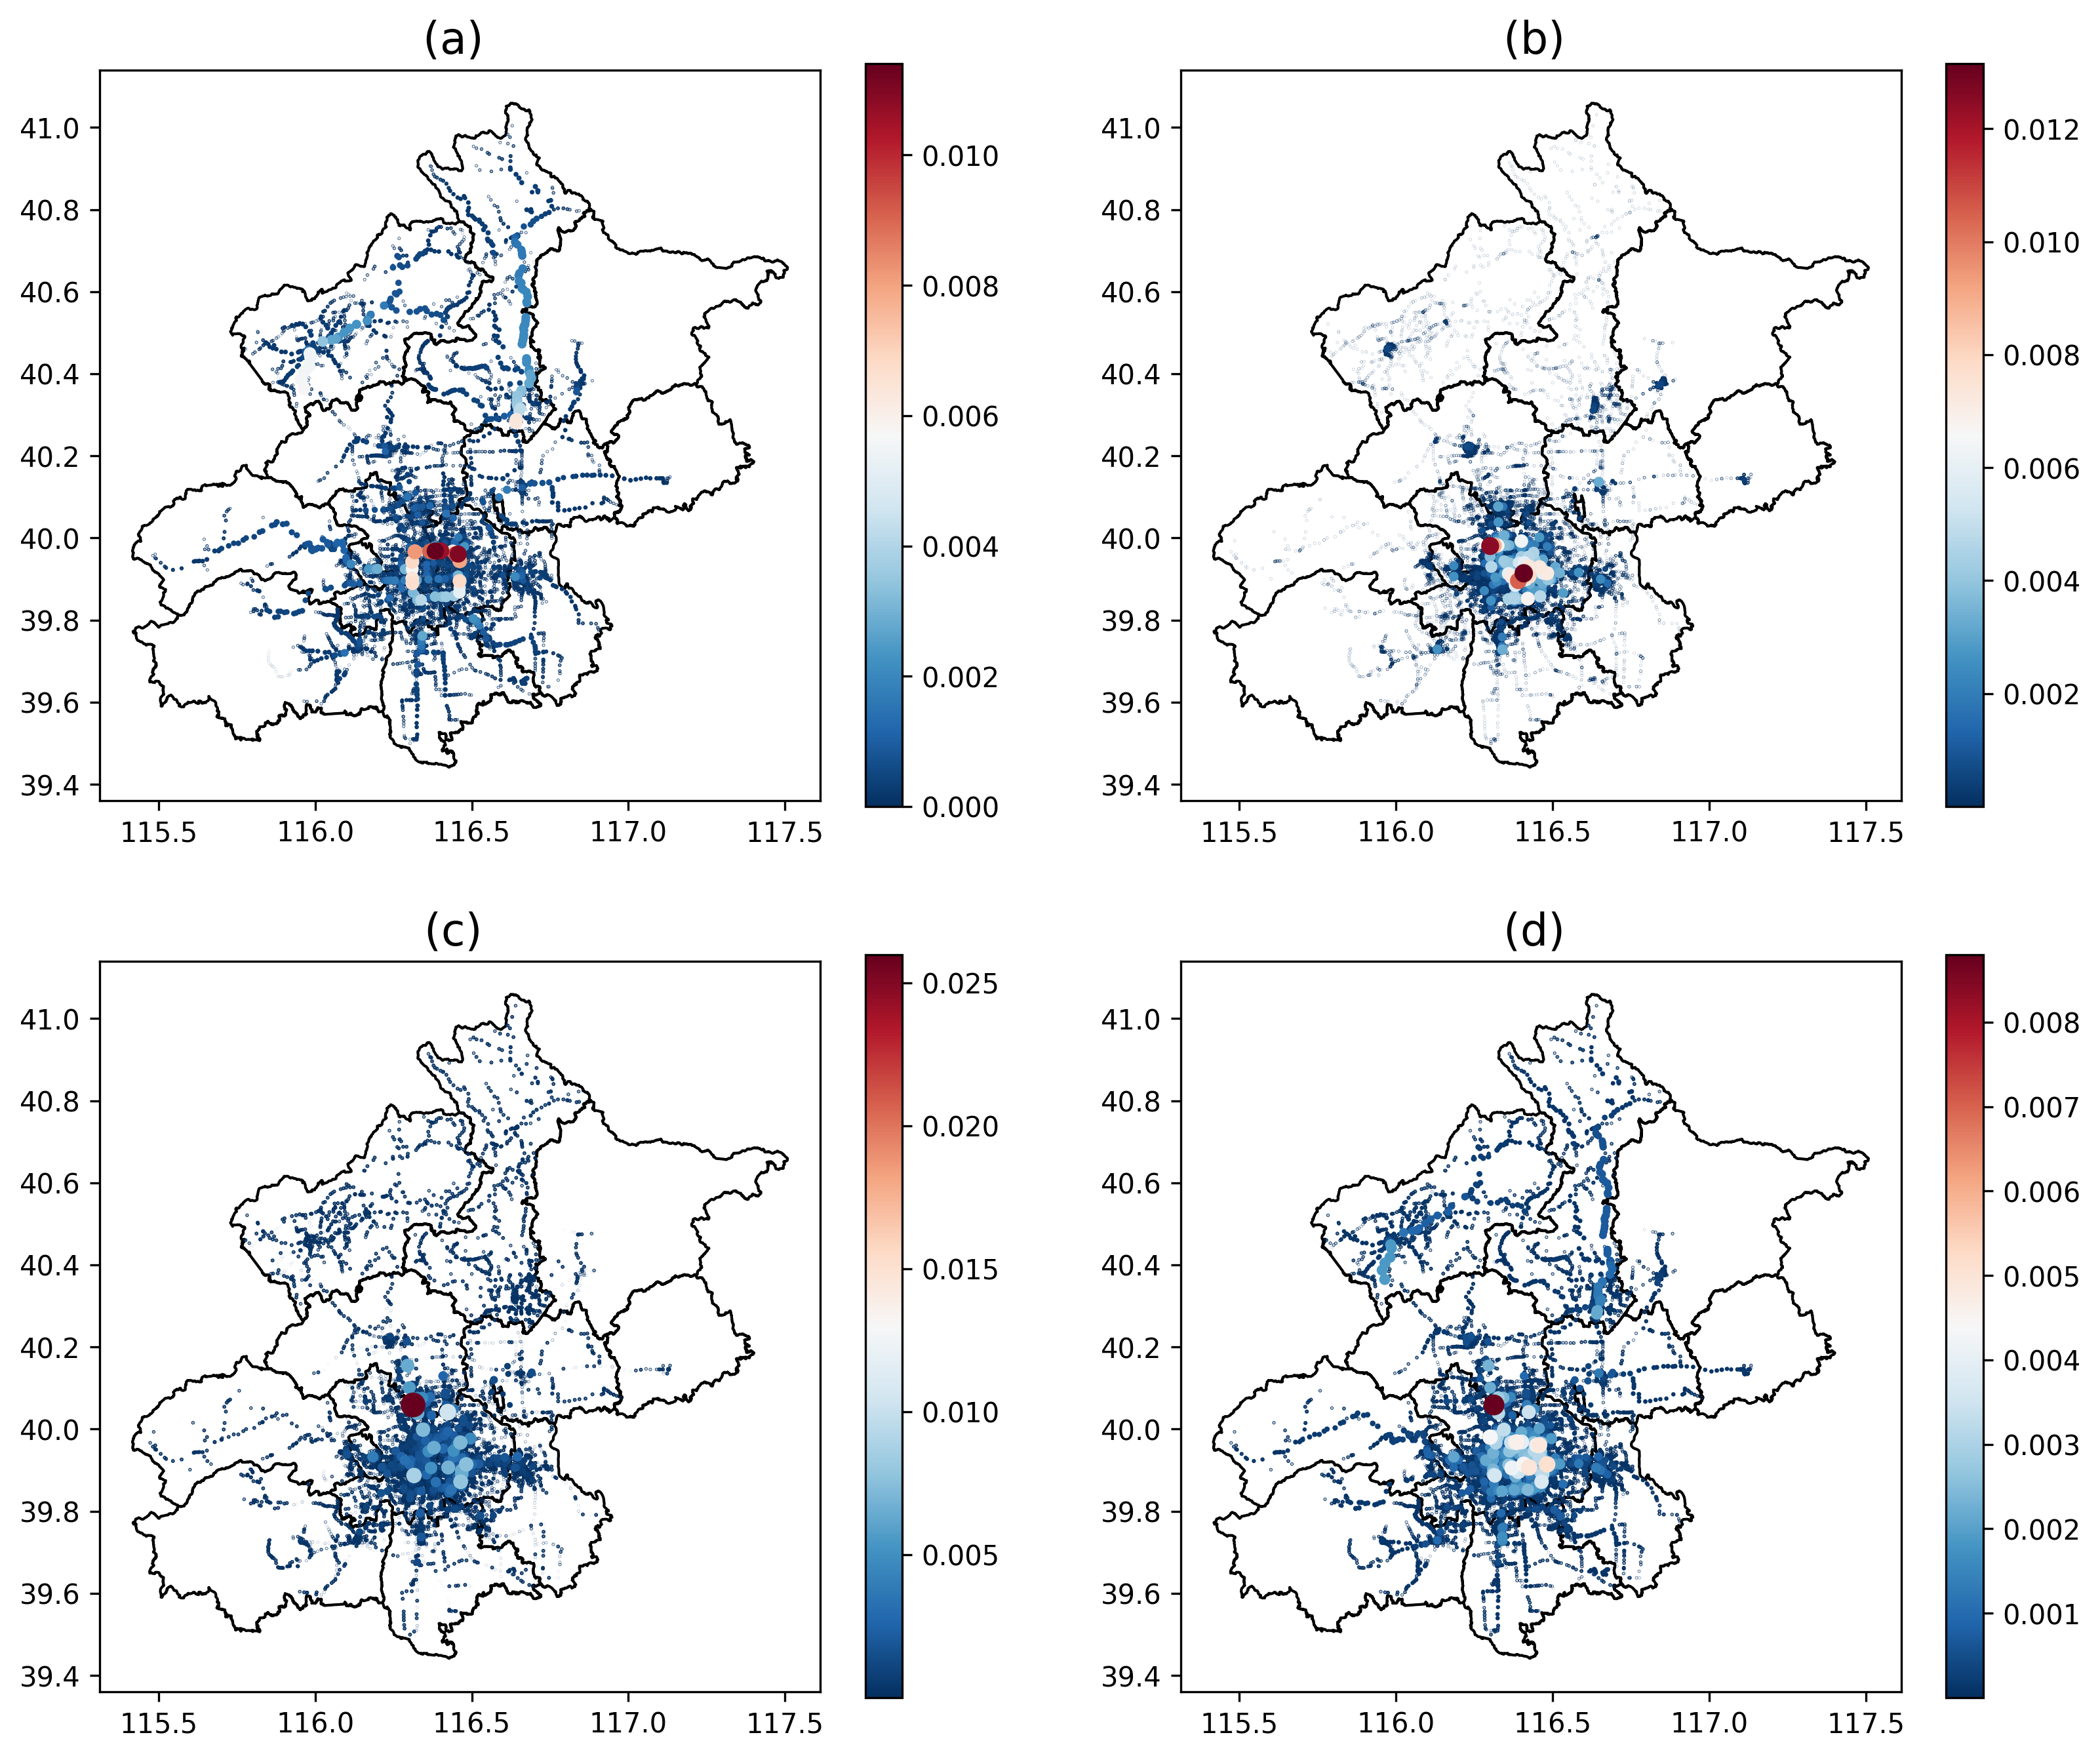

In [752]:
#
fig,ax = plt.subplots(2,2,figsize=(13,11),dpi=300)
fig=plt.gcf()
fig.set_facecolor('white')
# 
gemmbs2=gemmbs1.sort_values(by=['strucutre_importance'],ascending=True)
beij.plot(ax=ax[0][0],facecolor='none',edgecolor='k')
gemmbs2.plot(ax=ax[0][0], marker='.',column='strucutre_importance', cmap='RdBu_r',
             markersize =gemmbs2['strucutre_importance']*10000,
             legend=True,legend_kwds={'orientation':'vertical','shrink':1},alpha=1)
ax[0][0].set_title(f'(a) ',fontsize=16)
# 【图2 POI重要度】
gemmbs3=gemmbs1.sort_values(by=['POI_W'],ascending=True)
beij.plot(ax=ax[0][1],facecolor='none',edgecolor='k')
gemmbs3.plot(ax=ax[0][1], marker='.',column='POI_W', cmap='RdBu_r',
             markersize =gemmbs3['POI_W']*10000,
             legend=True,legend_kwds={'orientation':'vertical','shrink':1},alpha=1)
ax[0][1].set_title(f'(b) ',fontsize=16)
# 【图3 功能重要度】
gemmbs4=gemmbs1.sort_values(by=['imv'],ascending=True)
beij.plot(ax=ax[1][0],facecolor='none',edgecolor='k')
gemmbs4.plot(ax=ax[1][0], marker='.',column='imv', cmap='RdBu_r',
             markersize =gemmbs4['imv']*10000,
             legend=True,legend_kwds={'orientation':'vertical','shrink':1},alpha=1)
ax[1][0].set_title(f'(c) ',fontsize=16)
# 【图4 节点重要度分布】
gemmbs5=gemmbs1.sort_values(by=['com_im'],ascending=True)
beij.plot(ax=ax[1][1],facecolor='none',edgecolor='k')
gemmbs5.plot(ax=ax[1][1], marker='.',column='com_im', cmap='RdBu_r',
             markersize =gemmbs5['com_im']*20000,
             legend=True,legend_kwds={'orientation':'vertical','shrink':1},alpha=1)
ax[1][1].set_title(f'(d) ',fontsize=16)
# fig.tight_layout()
fig.savefig(r'\nodes_importance_0.png', dpi=400)